In [20]:
from matplotlib import pyplot as plt
import jax.numpy as np
from jax.ops import index, index_update
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as onp
from scipy.linalg import expm
from jax import jit, grad, value_and_grad, vmap, jacrev
#from time import time
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.aer.pulse_new.de.DE_Problems import BMDE_Problem
from qiskit.providers.aer.pulse_new.de.DE_Solvers import BMDE_Solver
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.models.signals import VectorSignal, Constant, Signal, PiecewiseConstant
from qiskit.providers.aer.pulse_new.models.operator_models import OperatorModel
from qiskit.providers.aer.pulse_new.models.frame import Frame
from qiskit.providers.aer.pulse_new.optimize.optimize import find_pulse_bfgs_parallel, find_pulse_bfgs
from qiskit.providers.aer.pulse_new.optimize.opt_utils import diffeo

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 0. Overview

In this notebook we optimize a $\pi$-pulse in a simple qubit model using the `jax` version of new pulse simulator framework.

# 1. Model

The operators give a qubit model.

In [2]:
w = 5.
r = 1.

operators = [-1j * 2 * np.pi * w * Z / 2, -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(operators=operators)

The "signal" model is a piecewise constant signal 

In [4]:
# time step size
dt = 0.4

# simple low pass filter function for a piecewise constant signal
def lowpass(t, sig, cutoff=0.1):
    # assumes that t is in units of ns
    dt = t[1]-t[0]
    freqs = (1/dt)*np.fft.fftfreq(t.shape[-1])
    sig_fft = np.fft.fft(sig)
    filtered_sig_fft = sig_fft*(1/(1+1.0j*freqs/cutoff))
    filtered_sig = np.fft.ifft(filtered_sig_fft)
    return filtered_sig.real

# signal generator - given params, maps them to a piecewise constant signal
# bounded between [-1, 1], smoothed by the low pass filter, driven on resonance
def signal_generator(params):
    new_params = diffeo(params, [-1, 1])
    times = np.arange(params.shape[-1])*dt + dt
    new_params = lowpass(times, new_params)
    return [Constant(1.), PiecewiseConstant(dt=dt, samples=new_params, carrier_freq=w)]

In [5]:
frame = Frame(np.array(-1j * 2 * np.pi * w * Z.data / 2))

# unitary as function of params
def get_unitary(c_params):
    T = c_params.shape[-1] * dt
    gen_copy = generator.copy()
    #gen_copy.frame = np.array(-1j * 2 * np.pi * w * Z.data / 2)
    gen_copy.signals = signal_generator(c_params)
    problem = BMDE_Problem(gen_copy, 
                           y0=np.array([[1., 0.], [0., 1.]], dtype=complex), 
                           t0=0., 
                           frame=frame)
    solver = BMDE_Solver(problem, options=DE_Options(atol=1e-12, rtol=1e-12))
    solver.integrate(T)
    return solver.y

In [7]:
# fidelity to X gate
def X_fidelity(U):
    ip = (np.array([[0., 1.], [1., 0.]], dtype=complex).conj() * U).sum()
    return np.real(ip * ip.conj())/4

def obj(params):
    return 1 - X_fidelity(get_unitary(params))

In [11]:
# specifies number of time steps
ctrl_shape = (10,)
#results = find_pulse_bfgs_parallel(obj, ctrl_shape, shots=16, n_jobs=8) 
result = find_pulse_bfgs(obj, ctrl_shape, update_rate=10)

Optimizing pulse...
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7
Total time taken: 7.499068260192871


Plot the found pulse.

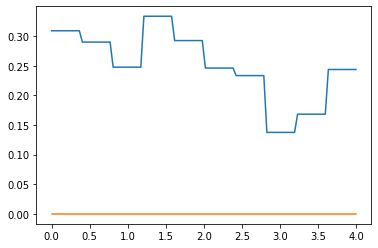

In [17]:
x_signal = signal_generator(result.x)[1]
x_signal.plot_envelope(0, ctrl_shape[0]*dt, 100)

Area under the pulse:

In [18]:
x_signal.samples.sum()*dt

DeviceArray(1.00000713, dtype=float64)

Expected area to do a $\pi$ pulse:

In [19]:
1/r

1.0